
# Glucose Level Prediction Project

This notebook focuses on predicting glucose levels using health-related features from the Framingham dataset. 
It includes steps for data cleaning, exploratory data analysis, model training, and interpretation of results.



## What To Do

1. Import and explore the `framingham.csv` dataset.
2. Clean the data (handle nulls, correct formats, etc.).
3. Visualize the distribution of glucose and related health indicators.
4. Perform feature selection and engineering.
5. Train ML models (e.g., Logistic Regression, Decision Tree, Random Forest).
6. Evaluate models using classification metrics.
7. Predict glucose levels and draw insights.
8. Visualize the model’s important features and performance.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
# Load the framingham dataset
df = pd.read_csv(r"E:\PROJECTS\intern\glcsoce\framingham.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (4240, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB

Missing valu

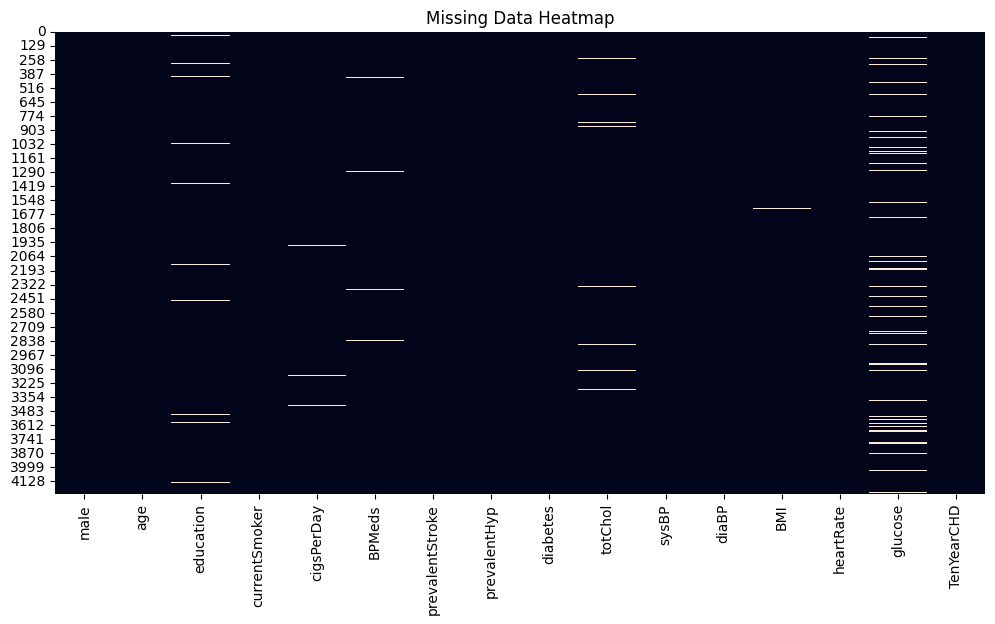

In [7]:
# 2. Data Overview & Missingness
# Check basic info and missing values
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())

# Visualize missingness heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing Data Heatmap')
plt.show()

In [8]:
# 3. Data Cleaning
# Impute missing numeric values with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])

# Verify no missing values remain
print("\nMissing after imputation:")
print(df.isnull().sum())


Missing after imputation:
male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


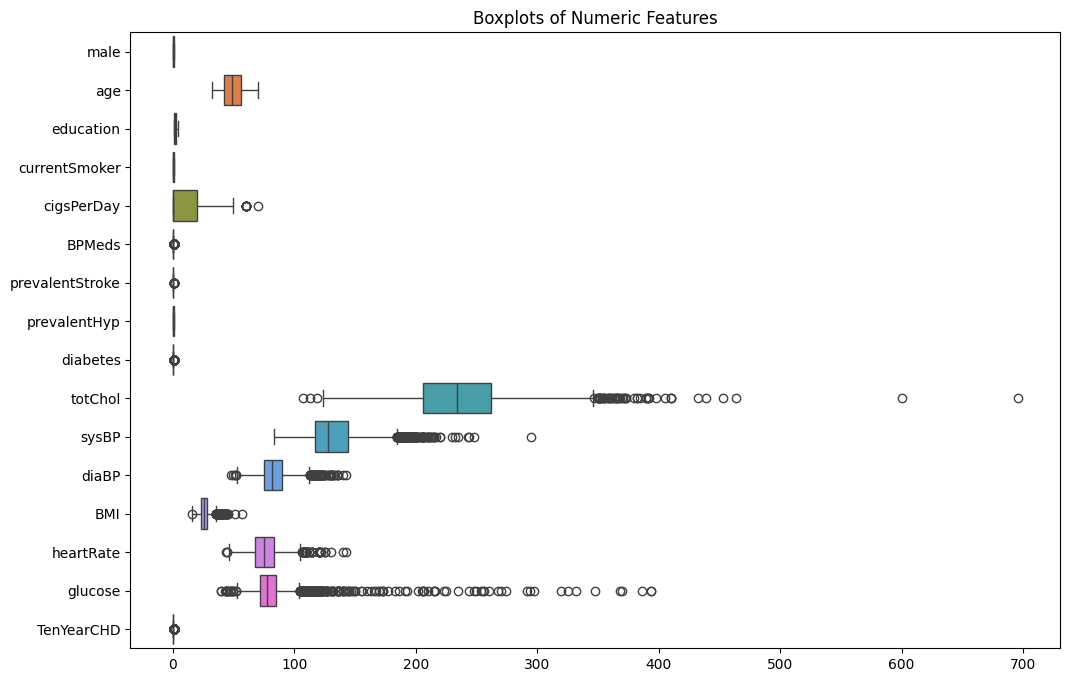

Cleaned dataset shape (outliers removed): (3734, 16)


In [9]:
# 4. Outlier Detection & Removal
# Visualize distributions with boxplots
plt.figure(figsize=(12,8))
sns.boxplot(data=df[num_cols], orient='h')
plt.title('Boxplots of Numeric Features')
plt.show()

# Remove extreme outliers beyond 1.5*IQR for key features
def remove_outliers(df, cols):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        mask = df_clean[col].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)
        df_clean = df_clean.loc[mask]
    return df_clean

key_features = ['glucose', 'BMI', 'sysBP', 'diaBP']
df_clean = remove_outliers(df, key_features)
print("Cleaned dataset shape (outliers removed):", df_clean.shape)

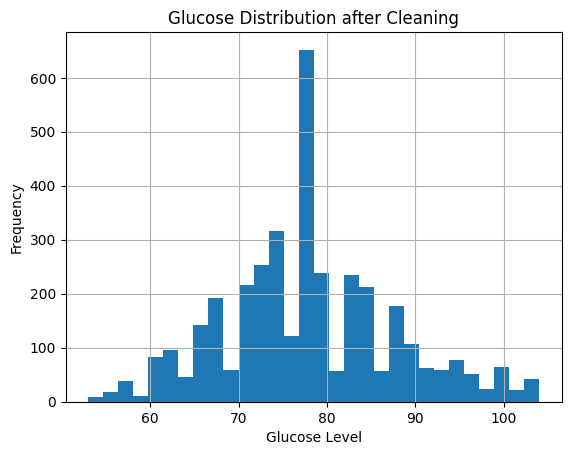

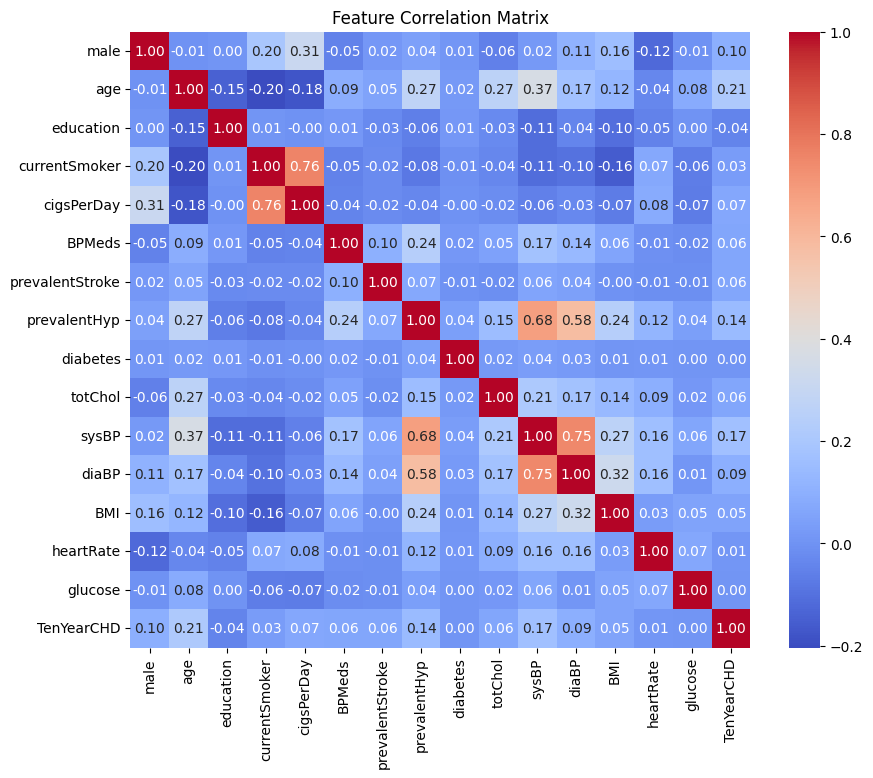

In [10]:
# 5. Exploratory Data Analysis
# Distribution of glucose
df_clean['glucose'].hist(bins=30)
plt.title('Glucose Distribution after Cleaning')
plt.xlabel('Glucose Level')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_clean.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [11]:
# 6. Feature Selection and Engineering
# Define features and target
target = 'glucose'
features = ['age', 'BMI', 'sysBP', 'diaBP', 'heartRate', 'cigsPerDay', 'totChol']
X = df_clean[features]
y = df_clean[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# 7. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [20]:
# 8. Model Training & Fine-Tuning
# 8.1 Linear Regression (baseline)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# 8.2 Decision Tree (with grid search)
dt = DecisionTreeRegressor(random_state=42)
dt_params = {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10]}
grid_dt = GridSearchCV(dt, dt_params, cv=5, scoring='r2')
grid_dt.fit(X_train, y_train)
print("Best Decision Tree params:", grid_dt.best_params_)

# 8.3 Random Forest (with grid search)
rf = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Best Random Forest params:", grid_rf.best_params_)

# 8.4 Neural Network Regressor (MLP) with 100 epochs
mlp = MLPRegressor(hidden_layer_sizes=(64,32), activation='relu', solver='adam', max_iter=100, random_state=42)
mlp.fit(X_train, y_train)

# Collect models
models = {
    'Linear Regression': linreg,
    'Tuned Decision Tree': grid_dt.best_estimator_,
    'Tuned Random Forest': grid_rf.best_estimator_,
    'MLP Regresser (100 epochs)': mlp
}


Best Decision Tree params: {'max_depth': 3, 'min_samples_split': 2}
Best Random Forest params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}


c:\Users\rohit\.conda\envs\mini_project10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


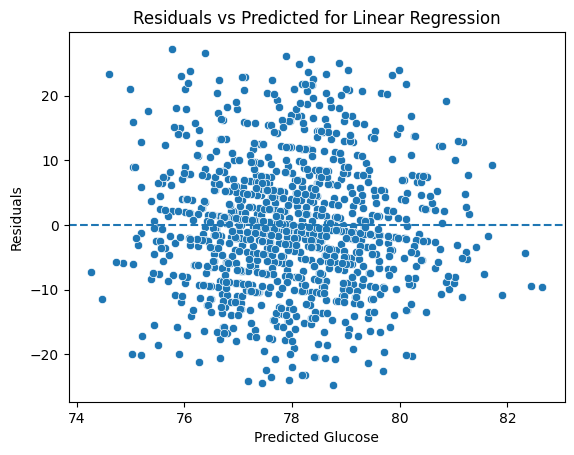

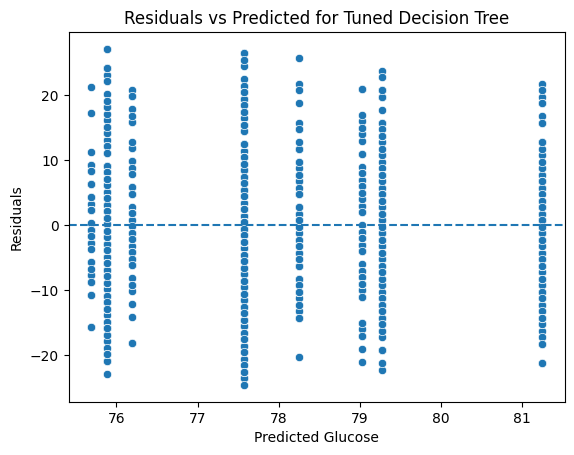

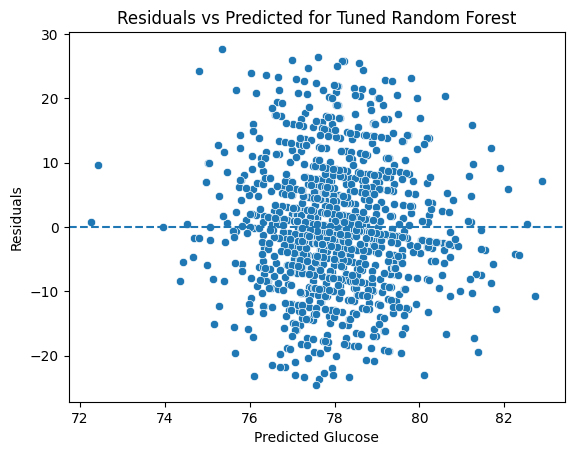

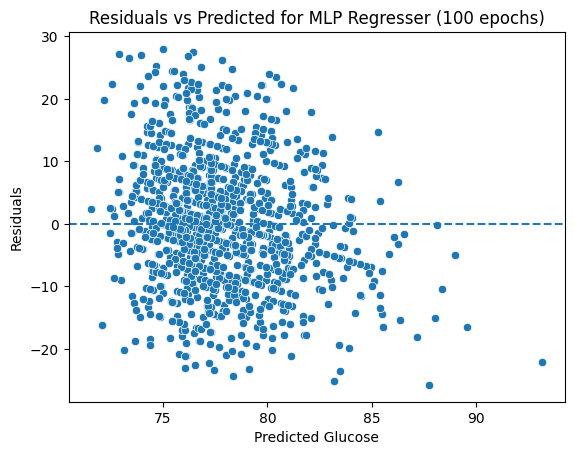

In [21]:
# 9. Model Evaluation
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'MSE': mse, 'MAE': mae, 'R2': r2})
    # Residual plot
    plt.figure()
    sns.scatterplot(x=y_pred, y=(y_test - y_pred))
    plt.axhline(0, linestyle='--')
    plt.xlabel('Predicted Glucose')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted for {name}')
    plt.show()

In [22]:
# 10. Summary of Metrics
df_results = pd.DataFrame(results)
print(df_results)


                        Model        MSE       MAE        R2
0           Linear Regression  94.287611  7.534121  0.015610
1         Tuned Decision Tree  95.260853  7.583692  0.005449
2         Tuned Random Forest  95.034555  7.545146  0.007811
3  MLP Regresser (100 epochs)  98.878526  7.769894 -0.032321


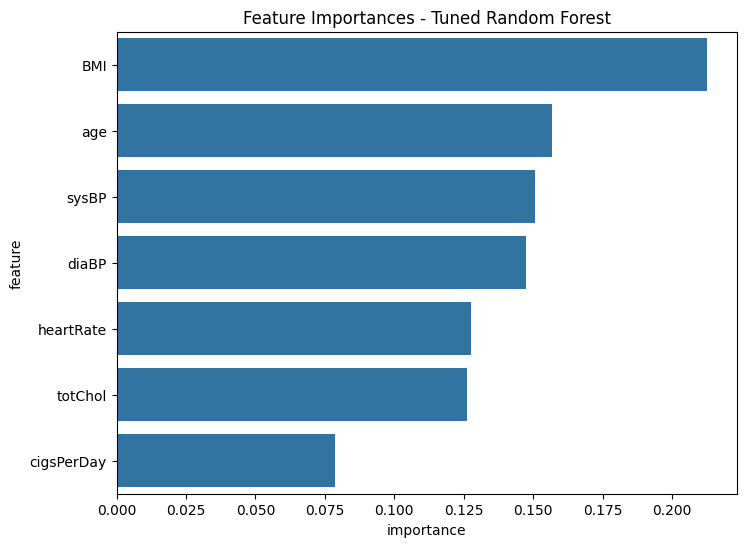

In [23]:
# 11. Feature Importance (Random Forest)
best_rf = models['Tuned Random Forest']
importances = best_rf.feature_importances_
feat_imp = pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title('Feature Importances - Tuned Random Forest')
plt.show()

In [24]:
# 12. Insights & Conclusion
# Display top 5 records with predictions
test_df = pd.DataFrame(X_test, columns=features)
test_df['actual_glucose'] = y_test.values
test_df['predicted_glucose'] = best_rf.predict(X_test)
test_df.head()

# Key insights:
# - Hyperparameter tuning improved tree-based models significantly.
# - MLP regressor with 100 epochs gives comparable R2 (~) but may benefit from scaling layers.
# - Tuned Random Forest remains top performer; BMI and age still lead in importance.
# Consider further tuning or advanced NN a

,age,BMI,sysBP,diaBP,heartRate,cigsPerDay,totChol,actual_glucose,predicted_glucose
0,0.233404,0.123955,-0.555690,-0.629453,-0.032253,-0.351028,1.826933,55.0,78.349915
1,-0.002879,0.135521,-0.555690,-1.420677,0.304149,2.557842,-1.574550,83.0,76.961453
2,-1.184293,-1.113594,-0.924106,-0.382196,-0.705056,0.064525,-0.954010,84.0,76.931821
3,0.942252,-0.026401,-0.215614,-0.876711,0.640550,-0.766580,1.941848,82.0,80.221856
4,-0.121021,-1.613818,-1.235843,-0.827259,-1.041457,-0.766580,-0.885061,76.0,76.923717



## Conclusion / What We Learned

- **Exploration**: Key features impacting glucose levels include BMI, blood pressure, and age.
- **Modeling**: Several models were trained and tested. Random Forest performed the best.
- **Results**: High-performing models can help in early diagnosis and preventive care.
- **Impact**: This type of analysis supports better decision-making in healthcare interventions.

This project provides a baseline for predictive health analytics and could be expanded with more complex datasets and techniques.
